In [1]:
import os
import sys
import re
import time
import yaml
import shutil
import argparse
import tarfile
import tempfile
import random
import subprocess
import copy

import torch

import boda
from boda.common import utils
from boda.common.utils import set_best, save_model, unpack_artifact, model_fn

import hypertune

import matplotlib.pyplot as plt
import seaborn as sns


# Copy generate.py

In [2]:
def save_proposals(proposals, args):
    save_dict = {
        'proposals': proposals,
        #'args'     : args,
        'timestamp'    : time.strftime("%Y%m%d_%H%M%S"),
        'random_tag'   : random.randint(100000,999999)
    }
    filename = f'proposals__{save_dict["timestamp"]}__{save_dict["random_tag"]}.pt'
    torch.save(save_dict, filename)
        
    if 'gs://' in args['Main args'].proposal_path:
        clound_target = os.path.join(args['Main args'].proposal_path,filename)
        subprocess.check_call(
            ['gsutil', 'cp', filename, clound_target]
        )
    else:
        os.makedirs(args['Main args'].proposal_path, exist_ok=True)
        shutil.copy(filename, args['Main args'].proposal_path)
    
    final_loc = os.path.join(args['Main args'].proposal_path,filename)
    print(f'Proposals deposited at:\n\t{final_loc}', file=sys.stderr)


In [3]:
if False:
    parser = argparse.ArgumentParser(description="BODA generator", add_help=False)
    group = parser.add_argument_group('Main args')
    
    group.add_argument('--params_module', type=str, required=True, help='')
    group.add_argument('--energy_module', type=str, required=True, help='')    
    group.add_argument('--generator_module', type=str, required=True, help='')
    group.add_argument('--penalty_module', type=str, help='')
    group.add_argument('--monitor', type=str, help='')
    group.add_argument('--n_proposals', type=list, help='')
    group.add_argument('--energy_threshold', type=float, default=float("Inf"))
    group.add_argument('--max_attempts', type=int, default=10000)
    group.add_argument('--reset_params', type=utils.str2bool, default=True)
    group.add_argument('--proposal_path', type=str)
    
    group.add_argument('--tolerate_unknown_args', type=utils.str2bool, default=False, help='Skips unknown command line args without exceptions. Useful for HPO, but high risk of silent errors.')
    
    known_args, leftover_args = parser.parse_known_args()
    
    Params    = getattr(boda.generator, known_args.params_module)
    Energy    = getattr(boda.generator.energy, known_args.energy_module)
    Generator = getattr(boda.generator, known_args.generator_module)
    
    parser = Params.add_params_specific_args(parser)
    parser = Energy.add_energy_specific_args(parser)
    parser = Generator.add_generator_constructor_specific_args(parser)
    parser = Generator.add_generator_runtime_specific_args(parser)
    
    if known_args.penalty_module is not None:
        Penalty = getattr(boda.generator.energy, known_args.penalty_module)
        parser = Penalty.add_penalty_specific_args(parser)
        
    parser.add_argument('--help', '-h', action='help')
    
    if known_args.tolerate_unknown_args:
        args, leftover_args = parser.parse_known_args()
        print("Skipping unexpected args. Check leftovers for typos:", file=sys.stderr)
        print(leftover_args, file=sys.stderr)
    else:
        args = parser.parse_args()
        
    args = boda.common.utils.organize_args(parser, args)
    
    main(args)

In [4]:
def main(args):
    
    args_copy = copy.copy(args)
    
    params_module     = getattr(boda.generator.parameters, args['Main args'].params_module)
    energy_module    = getattr(boda.generator.energy    , args['Main args'].energy_module)
    generator_module = getattr(boda.generator           , args['Main args'].generator_module)
    
    params_args     = vars(params_module.process_args(args))
    energy_args    = vars(energy_module.process_args(args))
    generator_args = generator_module.process_args(args)
    generator_constructor_args, generator_runtime_args = [ vars(arg_subset) for arg_subset in generator_args ]
    
    params    = params_module(**params_args)
    energy    = energy_module(**energy_args)
    
    if args['Main args'].penalty_module is not None:
        penalty_module = getattr(boda.generator.energy, args['Main args'].penalty_module)
        energy.__class__ = type(
            'energy_module',
            (energy_module, penalty_module),
            vars(penalty_module.process_args(args))
        )
    else:
        penalty_module = None
    current_penalty = None

    generator_constructor_args['params']    = params
    generator_constructor_args['energy_fn'] = energy
    generator_runtime_args['energy_threshold'] = args['Main args'].energy_threshold
    generator_runtime_args['max_attempts'] = args['Main args'].max_attempts
    generator = generator_module(**generator_constructor_args)
    
    params.cuda()
    energy.cuda()
    
    proposal_sets = []
    for get_n in args['Main args'].n_proposals:
        generator_runtime_args['n_proposals'] = get_n
        proposal = generator.generate(**generator_runtime_args)
        proposal['penalty'] = current_penalty
        proposal_sets.append(proposal)
        
        sns.histplot(proposal['energies'].numpy())
        plt.show()
        
        if args['Main args'].penalty_module is not None:
            current_penalty = energy.update_penalty(proposal)
            
        if args['Main args'].reset_params:
            generator.params = params_module(**params_args)
            
    save_proposals(proposal_sets, args_copy)
    return params, energy, generator, proposal_sets


# Write bash command

In [5]:
cmd_str = '--params_module BasicParameters ' +\
            '--batch_size 128 --n_channels 4 --length 200 ' +\
          '--energy_module OverMaxEnergy ' +\
            '--model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz ' +\
            '--bias_cell 0 --bending_factor 0 ' +\
          '--generator_module SimulatedAnnealing ' +\
            '--n_positions 1 --a 1 --b 1 --gamma 1 ' +\
            '--energy_threshold 1000.0 --max_attempts 20 --n_steps 100 ' +\
          '--penalty_module StremePenalty ' +\
            '--score_pct 0.3 ' +\
          '--proposal_path ./test_seqs/ --n_proposals 500 500 500 500 500 '

'python /home/ubuntu/boda2/src/generate.py ' + cmd_str

'python /home/ubuntu/boda2/src/generate.py --params_module BasicParameters --batch_size 128 --n_channels 4 --length 200 --energy_module OverMaxEnergy --model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz --bias_cell 0 --bending_factor 0 --generator_module SimulatedAnnealing --n_positions 1 --a 1 --b 1 --gamma 1 --energy_threshold 1000.0 --max_attempts 20 --n_steps 100 --penalty_module StremePenalty --score_pct 0.3 --proposal_path ./test_seqs/ --n_proposals 500 500 500 500 500 '

In [6]:
cmd_str = '--params_module StraightThroughParameters ' +\
            '--batch_size 128 --n_channels 4 --length 200 --n_samples 20 ' +\
          '--energy_module OverMaxEnergy ' +\
            '--model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz ' +\
            '--bias_cell 1 --bending_factor 1.0 ' +\
          '--generator_module FastSeqProp ' +\
            '--energy_threshold -2.0 --max_attempts 10 --n_steps 300 ' +\
          '--penalty_module StremePenalty ' +\
            '--score_pct 0.2 ' +\
          '--proposal_path ./test_seqs/ --n_proposals 500 500 500 500 500 '

'python /home/ubuntu/boda2/src/generate.py ' + cmd_str

'python /home/ubuntu/boda2/src/generate.py --params_module StraightThroughParameters --batch_size 128 --n_channels 4 --length 200 --n_samples 20 --energy_module OverMaxEnergy --model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz --bias_cell 1 --bending_factor 1.0 --generator_module FastSeqProp --energy_threshold -2.0 --max_attempts 10 --n_steps 300 --penalty_module StremePenalty --score_pct 0.0 --proposal_path ./test_seqs/ --n_proposals 500 500 500 500 500 '

# Parse command line

In [7]:
parser = argparse.ArgumentParser(description="BODA generator", add_help=False)
group = parser.add_argument_group('Main args')

group.add_argument('--params_module', type=str, required=True, help='')
group.add_argument('--energy_module', type=str, required=True, help='')    
group.add_argument('--generator_module', type=str, required=True, help='')
group.add_argument('--penalty_module', type=str, help='')
group.add_argument('--monitor', type=str, help='')
group.add_argument('--n_proposals', nargs='+', type=int, help='')
group.add_argument('--energy_threshold', type=float, default=float("Inf"))
group.add_argument('--max_attempts', type=int, default=10000)
group.add_argument('--reset_params', type=utils.str2bool, default=True)
group.add_argument('--proposal_path', type=str)

group.add_argument('--tolerate_unknown_args', type=utils.str2bool, default=False, help='Skips unknown command line args without exceptions. Useful for HPO, but high risk of silent errors.')

_StoreAction(option_strings=['--tolerate_unknown_args'], dest='tolerate_unknown_args', nargs=None, const=None, default=False, type=<function str2bool at 0x7f54490d8440>, choices=None, help='Skips unknown command line args without exceptions. Useful for HPO, but high risk of silent errors.', metavar=None)

In [8]:
known_args, leftover_args = parser.parse_known_args(
    cmd_str.rstrip().split()
)

known_args

Namespace(energy_module='OverMaxEnergy', energy_threshold=-2.0, generator_module='FastSeqProp', max_attempts=10, monitor=None, n_proposals=[500, 500, 500, 500, 500], params_module='StraightThroughParameters', penalty_module='StremePenalty', proposal_path='./test_seqs/', reset_params=True, tolerate_unknown_args=False)

In [9]:
Params    = getattr(boda.generator, known_args.params_module)
Energy    = getattr(boda.generator.energy, known_args.energy_module)
Generator = getattr(boda.generator, known_args.generator_module)


In [10]:
parser = Params.add_params_specific_args(parser)
parser = Energy.add_energy_specific_args(parser)
parser = Generator.add_generator_specific_args(parser)


In [11]:
if known_args.penalty_module is not None:
    Penalty = getattr(boda.generator.energy, known_args.penalty_module)
    parser = Penalty.add_penalty_specific_args(parser)


In [12]:
parser.add_argument('--help', '-h', action='help')

if known_args.tolerate_unknown_args:
    args, leftover_args = parser.parse_known_args( 
        cmd_str.rstrip().split()
    )
    print("Skipping unexpected args. Check leftovers for typos:", file=sys.stderr)
    print(leftover_args, file=sys.stderr)
else:
    args = parser.parse_args(
        cmd_str.rstrip().split()
    )

args = boda.common.utils.organize_args(parser, args)


Namespace(batch_dim=0, batch_size=128, bending_factor=1.0, bias_alpha=1.0, bias_cell=1, cat_axis=-1, energy_module='OverMaxEnergy', energy_threshold=-2.0, generator_module='FastSeqProp', init_seqs=None, learning_rate=0.5, left_flank='GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCATTACATCTGTGTGTTGGTTTTTTGTGTGAATCGATAGTACTAACATACGCTCTCCATCAAAACAAAACGAAACAAAACAAACTAGCAAAATAGGCTGTCCCCAGTGCAAGTGCAGGTGCCAGAACATTTCTCTGGCCTAACTGGCCGCTTGACG', length=200, lr_scheduler=True, max_attempts=10, model_artifact='gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz', monitor=None, n_channels=4, n_proposals=[500, 500, 500, 500, 500], n_samples=20, n_steps=300, params_module='StraightThroughParameters', penalty_module='StremePenalty', proposal_path='./test_seqs/', reset_params=True, right_flank='CACTGCGGCTCCTGCGATCTAACTGGCCGGTACCTGAGCTCGCTAGCCTCGAGGATATCAAGATCTGGCCTCGGCGGCCAAGCTTAGACACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGT

In [13]:
args

{'positional arguments': Namespace(),
 'optional arguments': Namespace(help=None),
 'Main args': Namespace(energy_module='OverMaxEnergy', energy_threshold=-2.0, generator_module='FastSeqProp', max_attempts=10, monitor=None, n_proposals=[500, 500, 500, 500, 500], params_module='StraightThroughParameters', penalty_module='StremePenalty', proposal_path='./test_seqs/', reset_params=True, tolerate_unknown_args=False),
 'Params Module args': Namespace(batch_dim=0, batch_size=128, cat_axis=-1, init_seqs=None, left_flank='GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCATTACATCTGTGTGTTGGTTTTTTGTGTGAATCGATAGTACTAACATACGCTCTCCATCAAAACAAAACGAAACAAAACAAACTAGCAAAATAGGCTGTCCCCAGTGCAAGTGCAGGTGCCAGAACATTTCTCTGGCCTAACTGGCCGCTTGACG', length=200, n_channels=4, n_samples=20, right_flank='CACTGCGGCTCCTGCGATCTAACTGGCCGGTACCTGAGCTCGCTAGCCTCGAGGATATCAAGATCTGGCCTCGGCGGCCAAGCTTAGACACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATC', token_dim=-2, use_aff

In [ ]:
args_copy = copy.copy(args)

# Run everything with Main

Loaded model from 20211110_194934 in eval mode


Steps:   0%|          | 0/300 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
Steps: 100%|██████████| 300/300 [01:15<00:00,  3.97it/s, Loss=-15.7, LR=1e-6]   


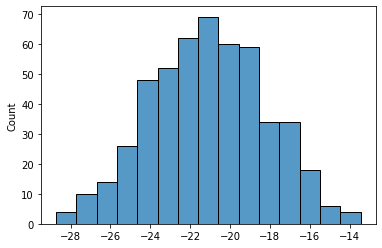

Steps: 100%|██████████| 300/300 [01:33<00:00,  3.22it/s, Loss=-14.5, LR=1e-6]   


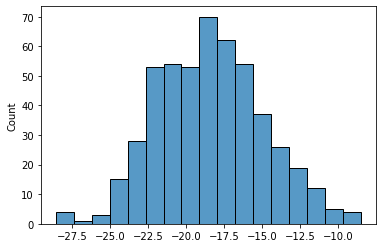

Steps: 100%|██████████| 300/300 [01:33<00:00,  3.21it/s, Loss=-5.49, LR=1e-6]   


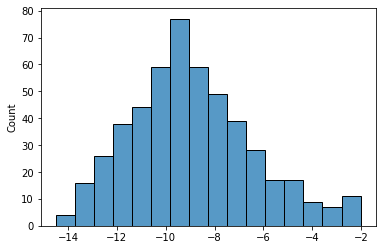

Steps: 100%|██████████| 300/300 [01:34<00:00,  3.18it/s, Loss=1.49, LR=1e-6]   


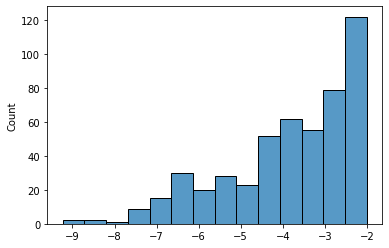

Steps: 100%|██████████| 300/300 [01:34<00:00,  3.17it/s, Loss=2.27, LR=1e-6]   


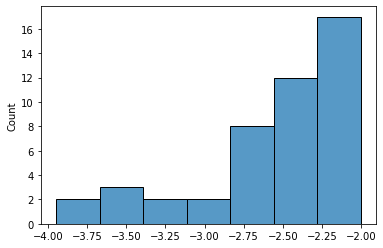

Proposals deposited at:
	./test_seqs/proposals__20211125_223322__345056.pt


In [14]:
params, energy, generator, proposal_sets = main(args)

In [19]:
for i in range(len(proposal_sets)):
    print(f'round {i}: {proposal_sets[i]["proposals"].shape[0]}')
    print(f'\taccpetance rate: {proposal_sets[i]["acceptance_rate"]}')


round 0: 500
	accpetance rate: 1.0
round 1: 500
	accpetance rate: 1.0
round 2: 500
	accpetance rate: 0.99609375
round 3: 500
	accpetance rate: 0.4609375
round 4: 46
	accpetance rate: 0.03593749925494194


# Check streme results

In [35]:
from boda.common import constants
from boda.common.utils import align_to_alphabet
from boda.generator.plot_tools import ppm_to_IC, matrix_to_dms
from boda.common.pymeme import parse_streme_output

def ppm_to_pcm(in_tensor, bkg=[0.25,0.25,0.25,0.25], contour_base=1.5):
    argument = in_tensor.div(torch.tensor(bkg).unsqueeze(1))
    motif = torch.log2(argument) #* contour_base ** torch.maximum(argument-1.9, torch.zeros_like(argument))
    return motif

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_order=alphabet,  out_order=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output, plot_type=ppm_to_IC):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    for motif_idx in range(len(motif_dict)):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(plot_type(motif_ppm), y_max=3)
        plt.show()
        matrix_to_dms(plot_type(motif_ppm_rc), y_max=3)
        plt.show()

In [36]:
proposal_sets[4]['penalty']['filters'].shape
pen_round = 2

{'alength': 4, 'w': 15, 'nsites': 475, 'E': 1.3e-22}


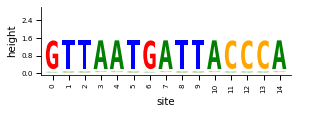

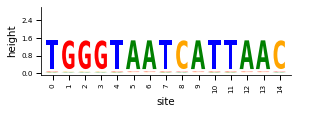

{'alength': 4, 'w': 10, 'nsites': 141, 'E': 0.00025}


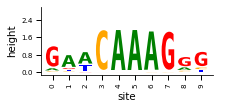

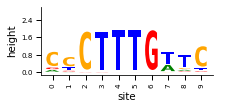

{'alength': 4, 'w': 13, 'nsites': 306, 'E': 0.00041}


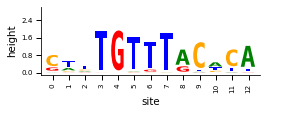

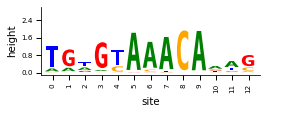

{'alength': 4, 'w': 12, 'nsites': 78, 'E': 0.035}


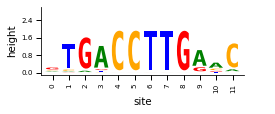

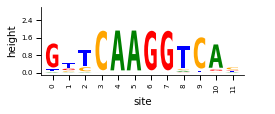

{'alength': 4, 'w': 8, 'nsites': 95, 'E': 0.31}


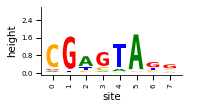

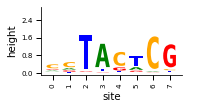

{'alength': 4, 'w': 10, 'nsites': 81, 'E': 0.34}


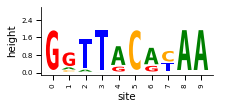

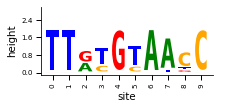

{'alength': 4, 'w': 8, 'nsites': 77, 'E': 0.36}


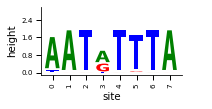

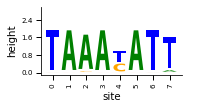

{'alength': 4, 'w': 9, 'nsites': 115, 'E': 0.55}


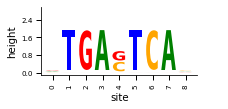

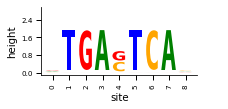

{'alength': 4, 'w': 9, 'nsites': 81, 'E': 0.55}


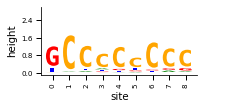

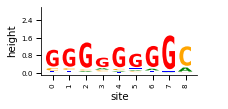

{'alength': 4, 'w': 10, 'nsites': 167, 'E': 1.9}


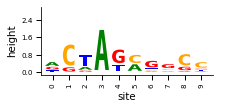

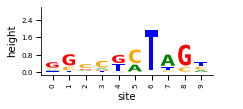

{'alength': 4, 'w': 9, 'nsites': 56, 'E': 7.9}


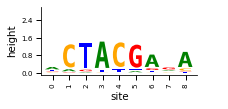

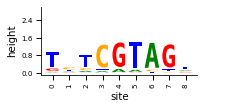

{'alength': 4, 'w': 9, 'nsites': 95, 'E': 8.9}


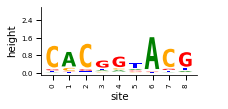

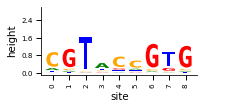

In [37]:
show_streme_motifs(
    parse_streme_output(proposal_sets[pen_round]['penalty']['streme_output']['output']),
    plot_type=ppm_to_IC
)

{'alength': 4, 'w': 15, 'nsites': 475, 'E': 1.3e-22}


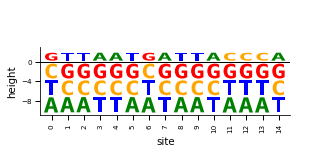

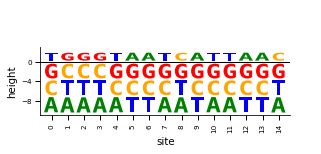

{'alength': 4, 'w': 10, 'nsites': 141, 'E': 0.00025}


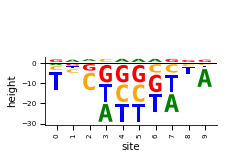

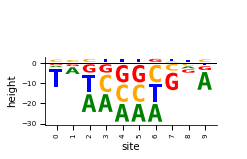

{'alength': 4, 'w': 13, 'nsites': 306, 'E': 0.00041}


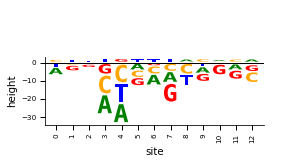

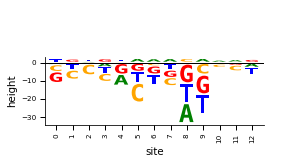

{'alength': 4, 'w': 12, 'nsites': 78, 'E': 0.035}


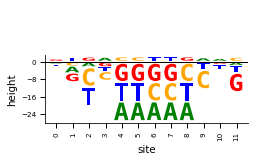

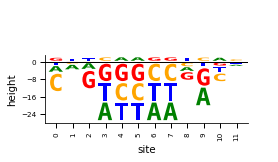

{'alength': 4, 'w': 8, 'nsites': 95, 'E': 0.31}


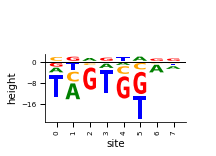

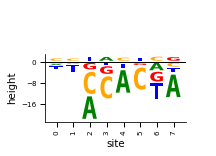

{'alength': 4, 'w': 10, 'nsites': 81, 'E': 0.34}


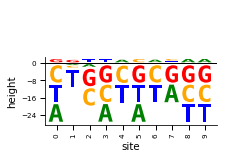

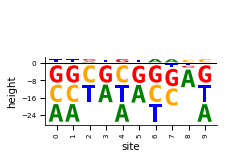

{'alength': 4, 'w': 8, 'nsites': 77, 'E': 0.36}


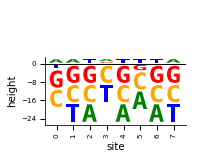

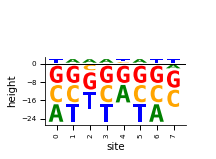

{'alength': 4, 'w': 9, 'nsites': 115, 'E': 0.55}


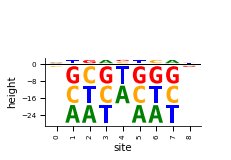

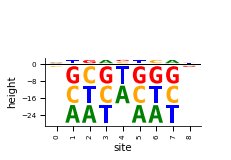

{'alength': 4, 'w': 9, 'nsites': 81, 'E': 0.55}


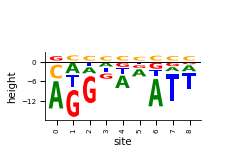

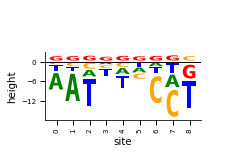

{'alength': 4, 'w': 10, 'nsites': 167, 'E': 1.9}


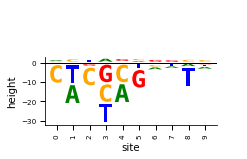

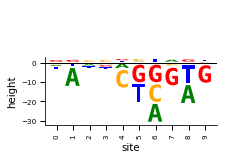

{'alength': 4, 'w': 9, 'nsites': 56, 'E': 7.9}


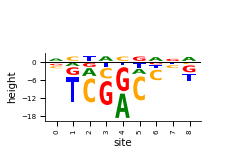

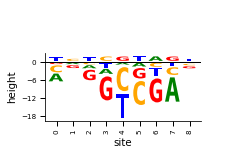

{'alength': 4, 'w': 9, 'nsites': 95, 'E': 8.9}


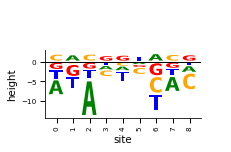

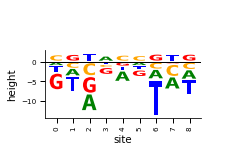

In [38]:
show_streme_motifs(
    parse_streme_output(proposal_sets[pen_round]['penalty']['streme_output']['output']),
    plot_type=ppm_to_pcm
)

# Break up to run step-wise

In [ ]:
def modules_from_args(args):
    
    params_module     = getattr(boda.generator.parameters, args['Main args'].params_module)
    energy_module    = getattr(boda.generator.energy    , args['Main args'].energy_module)
    generator_module = getattr(boda.generator           , args['Main args'].generator_module)
    
    params_args     = vars(params_module.process_args(args))
    energy_args    = vars(energy_module.process_args(args))
    generator_args = generator_module.process_args(args)
    generator_constructor_args, generator_runtime_args = [ vars(arg_subset) for arg_subset in generator_args ]
    
    params    = params_module(**params_args)
    energy    = energy_module(**energy_args)
    
    if args['Main args'].penalty_module is not None:
        penalty_module = getattr(boda.generator.energy, args['Main args'].penalty_module)
        energy.__class__ = type(
            'energy_module',
            (energy_module, penalty_module),
            vars(penalty_module.process_args(args))
        )
    else:
        penalty_module = None
    current_penalty = None

    generator_constructor_args['params']    = params
    generator_constructor_args['energy_fn'] = energy
    generator_runtime_args['energy_threshold'] = args['Main args'].energy_threshold
    generator_runtime_args['max_attempts'] = args['Main args'].max_attempts
    generator = generator_module(**generator_constructor_args)
    
    params.cuda()
    energy.cuda()
    
    return params, energy, generator


In [ ]:
params, energy, generator = modules_from_args(args_copy)

proposal_sets = []
for get_n in args['Main args'].n_proposals:
    generator_runtime_args['n_proposals'] = get_n
    proposal = generator.generate(**generator_runtime_args)
    proposal['penalty'] = current_penalty
    proposal_sets.append(proposal)

    sns.histplot(proposal['energies'].numpy())
    plt.show()

    if args['Main args'].penalty_module is not None:
        current_penalty = energy.update_penalty(proposal)

    if args['Main args'].reset_params:
        generator.params = params_module(**params_args)


In [ ]:
save_proposals(proposal_sets, args_copy)